# Метод частичной дискретизации с условиями излучения

$$\begin{cases}
u_{xx}+u_{yy}+\varkappa^2 \rho(x,y)\ u=f(x,y),\quad (x,y)\in(0,a)\times(0,b), \\
u(x,0)=u(x,b)=0, \\
f(x,y) \equiv 0,\quad \text{при}\ x\not\in [0,a].
\end{cases}$$

In [347]:
"""
A, B, C - вектор матриц, F - массив векторов. \n
Если, например, А - матрица, считаем, что предполагается вектор одинаковых матриц. \n
Если и A, и B, и С, и F - не векторы, длина вектора решения указывается через аргумент len.
"""
function matrix_thomas(A, B, C, F; typ=Float64, len=1, F_left=nothing)
    v = filter(a->!(eltype(a) <: Number),[A,B,C,F])
    N = len == 1 ? length(v[1]) : len
    K = len == 1 ? size(v[1][1],1) : size(A,1)
    a = zeros(typ,N+1,K,K)
    b = zeros(typ,N+1,K)

    inside(a,b) = true in map(el->isequal(el,a),b)
    
    An = inside(A,v) ? n->A[n] : n->A
    Bn = inside(B,v) ? n->B[n] : n->B
    Cn = inside(C,v) ? n->C[n] : n->C
    Fn = inside(F,v) ? n->F[n] : n->F

    for n = 1:N
        a[n+1,:,:] = -Cn(n) / (An(n)*a[n,:,:] + Bn(n))
        b[n+1,:] = (Fn(n) - An(n)*b[n,:])' / (An(n)*a[n,:,:] + Bn(n))
        println("direct, step: $n")
    end

    x = zeros(typ,K,N+1)
    for n = N:-1:1
        x[:,n] = a[n+1,:,:]*x[:,n+1] + b[n+1,:]
        println("reverse, step: $n")
    end

    return x[:,1:N]
end

matrix_thomas

In [184]:
a, b = 2, 1
k = 12
a1, a2 = 0.5, 1.5
r1, r2 = 1, 1.8

K = 200
N_ = 200
h = a/(N_-1)
x = range(0,stop=a,length=N_)
y = range(0,stop=b,length=K)

mu(k) = pi*k/b
f(y,k) = sqrt(2/b)*sin(pi*k/b*y)

f (generic function with 2 methods)

In [9]:
f(x) = 0.2*(x-a1)/(a2-a1)
g(x) = x <= a1 ? 0 : x <= a2 ? f(x) : 0.2

f1 = x -> b/2-0.1 - g(x)
f2 = x -> b/2 - g(x)
f3 = x -> b/2 + g(x)
f4 = x -> b/2+0.1 + g(x)

#31 (generic function with 1 method)

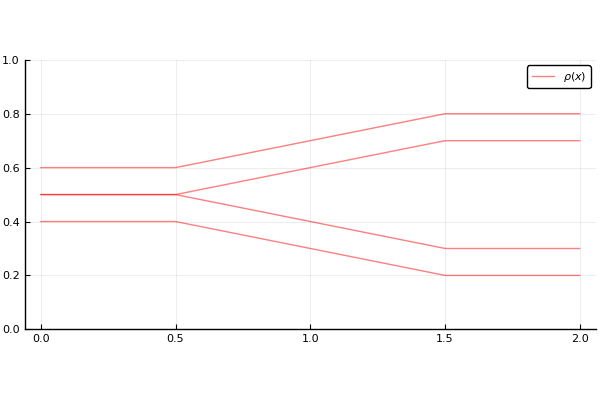

In [360]:
using LaTeXStrings
using Plots
pyplot(fmt="png")

plot( x, f1.(x), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, label=L"\rho(x)")
plot!(x, f2.(x), c=:red, alpha=0.5, label="")
plot!(x, f3.(x), c=:red, alpha=0.5, label="")
plot!(x, f4.(x), c=:red, alpha=0.5, label="")

In [11]:
using LinearAlgebra
using SymPy

y1 = Sym("y")
k1,k2 = symbols("k_1 k_2", positive=true, integer=true)
ff = simplify(integrate( 2/Sym(b)*sin(pi*k1/Sym(b)*y1)*sin(pi*k2/Sym(b)*y1), y1 ))

⎧2⋅(-k₁⋅sin(π⋅k₂⋅y)⋅cos(π⋅k₁⋅y) + k₂⋅sin(π⋅k₁⋅y)⋅cos(π⋅k₂⋅y))             
⎪────────────────────────────────────────────────────────────  for k₁ ≠ k₂
⎪                         ⎛  2     2⎞                                     
⎪                       π⋅⎝k₁  - k₂ ⎠                                     
⎪                                                                         
⎨                            sin(2⋅π⋅k₂⋅y)                                
⎪                   π⋅k₂⋅y - ─────────────                                
⎪                                  2                                      
⎪                   ──────────────────────                      otherwise 
⎪                            π⋅k₂                                         
⎩                                                                         

\begin{equation*} \int\limits_0^b\varphi_{k_1}(y)\rho(x_n,y)\varphi_{k_2}(y)dy = 
   \begin{cases}
   I_1,\ x_n\in (0,a_1), \\
   I_2,\ x_n\in [a_1,a_2], \\
   I_3,\ x_n\in (a_2,a).
   \end{cases}
\end{equation*}
$I_1 = \rho_1\delta_{k_1,k_2} + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}-0.1}^{\frac{b}{2}+0.1}
\varphi_{k_1}\varphi_{k_2}dy,$  
$I_2 = \rho_1\delta_{k_1,k_2} + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}-0.1-f(x_n)}^{\frac{b}{2}-f(x_n)}
\varphi_{k_1}\varphi_{k_2}dy  + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}+f(x_n)}^{\frac{b}{2}+0.1+f(x_n)}
\varphi_{k_1}\varphi_{k_2}dy,$  
$I_3 = \rho_1\delta_{k_1,k_2} + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}-0.3}^{\frac{b}{2}-0.2}
\varphi_{k_1}\varphi_{k_2}dy  + (\rho_2-\rho_1)\int\limits_{\frac{b}{2}+0.2}^{\frac{b}{2}+0.3}
\varphi_{k_1}\varphi_{k_2}dy,$

In [79]:
ff_ij = lambdify(evalf( ff[:args]()[1][:args]()[1] ),[k1,k2,y1])
ff_ii = lambdify(evalf( ff[:args]()[2][:args]()[1] ),[k2,y1])
I_ij(i,j,n)   = ff_ij(i,j,f4(x[n]))-ff_ij(i,j,f3(x[n]))+ff_ij(i,j,f2(x[n]))-ff_ij(i,j,f1(x[n]))
I_ii(i,n)     = ff_ii(i,  f4(x[n]))-ff_ii(i,  f3(x[n]))+ff_ii(i,  f2(x[n]))-ff_ii(i,  f1(x[n]))

function YrY(n,K)
    global r1,r2
    yry = zeros(K,K)
    for i=1:K, j=i+1:K
        yry[i,j] = I_ij(i,j,n)
        yry[j,i] = yry[i,j]
    end
    for i=1:K
        yry[i,i] = I_ii(i,n)
    end
    return  I*r1 + (r2-r1)*yry
end

YrY (generic function with 2 methods)

In [373]:
using LinearAlgebra

K_cross = K
M_square = diagm(0=>mu.(1:K_cross).^2)
A1 = k^2*YrY(1,K_cross) - M_square
L1 = eigvals(A1)
J = filter(z->L1[z]>0,1:K_cross)

4-element Array{Int64,1}:
 197
 198
 199
 200

In [374]:
c = eigvecs(A1);

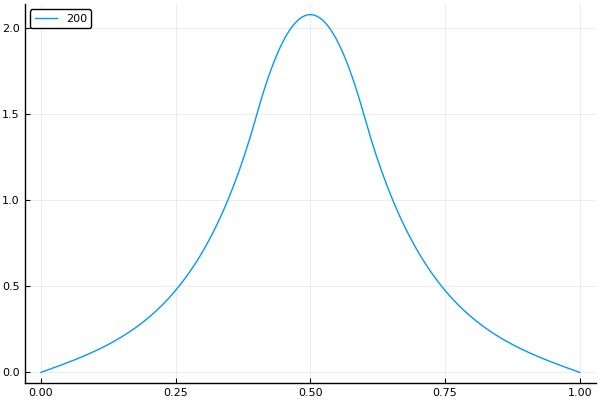

In [375]:
cross_section(y,n) = sum([f(y,i)*c[i,n] for i=1:K])

plot(legend=:topleft)
for i in J[end:end]
    plot!(y, cross_section.(y,i), label="$i")
end
plot!()

Невязка:
$r_n(y)=\Psi_1 C_1(\varkappa^2\rho(x_0,y)-\gamma_n^2-\mu_1^2)+\dotso+\Psi_K C_K (\varkappa^2\rho(x_0,y)-
  \gamma_n^2-\mu_K^2)$

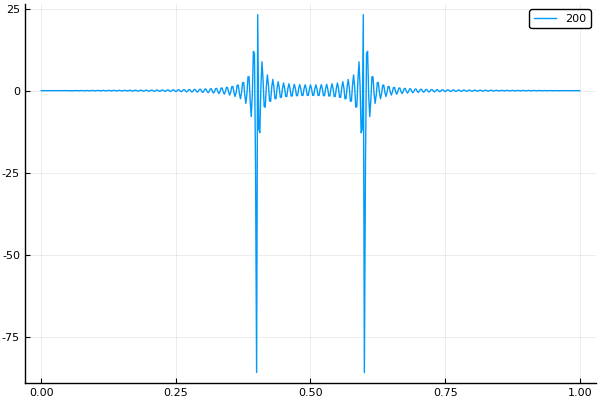

In [376]:
residual(y0,n) = sum([f(y0,i)*c[i,n]*(k^2*(z -> f1(0)<z<f4(0) ? r2 : r1)(y0)-L1[n]-mu(i)^2) for i=1:K])
plot()
for k in J[end:end]
    plot!(0:b/500:b,residual.(0:b/500:b,k),label="$k")
end
plot!()

In [377]:
sqrt.(L1[J]).-k

4-element Array{Float64,1}:
 -9.417636273318468 
 -3.231251273662304 
 -1.400696759085605 
  2.1313094179614716

In [378]:
sqrt(L1[J[end]])

14.131309417961472

In [379]:
gamma1 = sqrt.(Complex.(L1[end-K+1:end]));

In [380]:
A3 = k^2*YrY(N_,K_cross) - M_square
L3 = eigvals(A3)
gamma3 = sqrt.(Complex.(L3[end-K+1:end]));

Условия излучения:  
$\begin{cases}
\left.(i\Gamma_{(1)} X+X')\right|_{x=0} = 2i\Gamma_{(1)} A, \\
\left.(i\Gamma_{(3)} X-X')\right|_{x=a} = 2i\Gamma_{(3)} B.
\end{cases}$

In [381]:
M_square = diagm(0=>mu.(1:K).^2)
G1 = diagm(0=>gamma1)
G3 = diagm(0=>gamma3);

In [382]:
A = diagm(0=>ones(K))
B1 = fill(-2*I - h^2*M_square + h^2*k^2*YrY(1),  sum(x .<= a1)-2)
B2 = [-2*I - h^2*M_square + h^2*k^2*YrY(n) for n in filter(i->(a1 .< x[i] .< a2), 1:N_)]
B3 = fill(-2*I - h^2*M_square + h^2*k^2*YrY(N_), sum(a2 .<= x .<= a)-2)
B = [[B1[1]/2+h*im*G1]; B1; B2; B3; [B3[1]/2+h*im*G3]]
C_ = diagm(0=>ones(K));

In [383]:
F0 = 2h*im*G1*[1; zeros(K-1)]
F = [[F0]; fill(zeros(K),N_-3)];

In [384]:
X_in = matrix_thomas(A,B,C_,F,typ=Complex)

direct, step: 1
direct, step: 2
direct, step: 3
direct, step: 4
direct, step: 5
direct, step: 6
direct, step: 7
direct, step: 8
direct, step: 9
direct, step: 10
direct, step: 11
direct, step: 12
direct, step: 13
direct, step: 14
direct, step: 15
direct, step: 16
direct, step: 17
direct, step: 18
direct, step: 19
direct, step: 20
direct, step: 21
direct, step: 22
direct, step: 23
direct, step: 24
direct, step: 25
direct, step: 26
direct, step: 27
direct, step: 28
direct, step: 29
direct, step: 30
direct, step: 31
direct, step: 32
direct, step: 33
direct, step: 34
direct, step: 35
direct, step: 36
direct, step: 37
direct, step: 38
direct, step: 39
direct, step: 40
direct, step: 41
direct, step: 42
direct, step: 43
direct, step: 44
direct, step: 45
direct, step: 46
direct, step: 47
direct, step: 48
direct, step: 49
direct, step: 50
direct, step: 51
direct, step: 52
direct, step: 53
direct, step: 54
direct, step: 55
direct, step: 56
direct, step: 57
direct, step: 58
direct, step: 59
direct

200×198 Array{Complex,2}:
       2.0021+4.70996e-12im  …      0.041811+1.4887e-14im 
 -1.14612e-18+9.45466e-27im      2.81847e-18-2.95072e-29im
  -0.00620073-8.553e-13im         2.02626e-5+7.86605e-15im
 -1.20564e-19-1.51807e-27im      8.83257e-19+3.50268e-30im
   0.00372737+5.53575e-13im      -0.00361488-2.17136e-15im
  9.96861e-19+6.98369e-28im  …  -2.23212e-19+6.81615e-30im
   -0.0020973-1.8567e-13im       -0.00157706-9.0534e-16im 
 -3.04051e-19-3.25555e-28im     -9.85395e-19-3.13305e-30im
   0.00059326+2.64332e-14im       0.00105441+6.32899e-16im
 -1.03412e-19+1.10553e-28im       1.4413e-19-1.83662e-30im
  0.000298579+3.31852e-14im  …   0.000460822+1.93211e-16im
  4.71437e-19+1.79751e-29im      4.00778e-19+2.74121e-30im
 -0.000654169-4.18551e-14im     -0.000360437-2.66103e-16im
             ⋮               ⋱                            
   1.28299e-6-5.78876e-14im       1.23214e-7+1.74987e-17im
 -2.05742e-22-5.20581e-27im      3.44574e-23-7.04407e-29im
   1.22983e-6+1.96823e-13im  …

In [396]:
X0 = X_in[:,2] + 2h*im*G1*(X_in[:,1]-2*[1; zeros(K-1)])
XN = X_in[:,end-1] - 2h*im*G3*X_in[:,end]
X_sol = real.([X0 X_in XN])
u = reshape([dot(f.(y_i,1:K), X_sol[1:K,n]) for n=1:N_ for y_i in y], length(y), length(x));

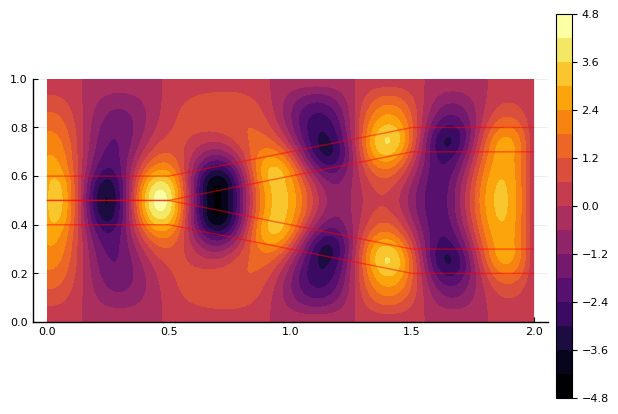

In [372]:
plot(x,y,u,fill=true,aspect_ratio=1)
plot!(x, f1.(x), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, leg=false)
plot!(x, f2.(x), c=:red, alpha=0.5)
plot!(x, f3.(x), c=:red, alpha=0.5)
plot!(x, f4.(x), c=:red, alpha=0.5)
# savefig("waveguide.png") # K_cross = 4000

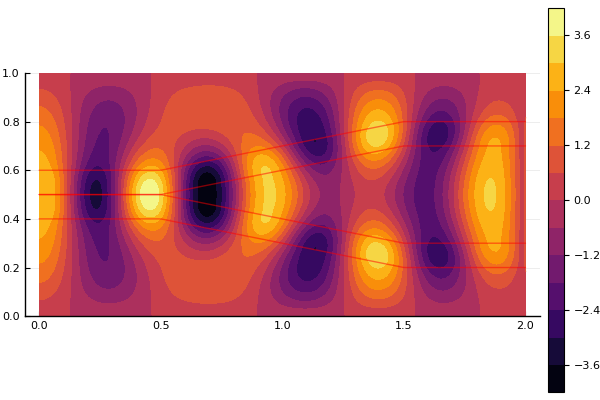

In [399]:
plot(x,y,u,fill=true,aspect_ratio=1)
plot!(x, f1.(x), c=:red, alpha=0.5, ylim=(0,b), aspect_ratio=1, leg=false)
plot!(x, f2.(x), c=:red, alpha=0.5)
plot!(x, f3.(x), c=:red, alpha=0.5)
plot!(x, f4.(x), c=:red, alpha=0.5)